## Deep RNN para Time Series + Deep RNN con SimpleRNN

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl

Using TensorFlow backend.


#### Generacion de series temporales Artificiales

In [2]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size,1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)
    return series[...,np.newaxis].astype(np.float32)

#### Creacion del Test y Train Set

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000,:n_steps], series[:7000,-1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:,:n_steps], series[9000:,-1]


X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

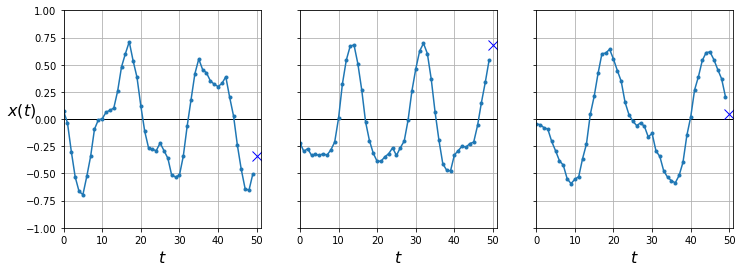

In [4]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()

### Entreamiento con Deep SimpleRNN

Esta red construye una RNN con varas capas de celulas RNN. No hay necesidad de especificar el tamano del input shape ya que puede procesar cadenas de cualquier tamano. 

Algunas cosas:
- Esta red usa por defecto la funcion de activacion de Tangente Hiperbolica.
- el estado inicial de $h_{(t)} es 0$
- $h_{(t)}$ se comporta se retroalimenta la neurona con informacion anterior.
- por defecto keras solamente retorna el valor del ultimo step t. 
- para devolver sequencias se debe definir return_sequences = True

**Nota**

la ultima capa keras.layers.SimpleRNN(1), solamente produce como resultado 1 sola unidad en el tiempo t donde el resultado varia entre -1 y 1. Tambien se puede reemplazar esta capa por Dense, donde podemos cambiar la funcion de activacion.

In [5]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences = True, input_shape=[None,1]),
    keras.layers.SimpleRNN(20, return_sequences = True),
    keras.layers.SimpleRNN(1),
])

model.compile(loss='mse', optimizer="adam", metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=20, verbose=1,  validation_data=(X_valid, y_valid))


Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 7s 955us/step - loss: 0.0134 - mae: 0.0771 - mse: 0.0134 - val_loss: 0.0045 - val_mae: 0.0536 - val_mse: 0.0045
Epoch 2/20
7000/7000 [==============================] - 6s 826us/step - loss: 0.0038 - mae: 0.0494 - mse: 0.0038 - val_loss: 0.0040 - val_mae: 0.0500 - val_mse: 0.0040
Epoch 3/20
7000/7000 [==============================] - 6s 825us/step - loss: 0.0033 - mae: 0.0462 - mse: 0.0033 - val_loss: 0.0031 - val_mae: 0.0450 - val_mse: 0.0031
Epoch 4/20
7000/7000 [==============================] - 6s 824us/step - loss: 0.0032 - mae: 0.0455 - mse: 0.0032 - val_loss: 0.0031 - val_mae: 0.0449 - val_mse: 0.0031
Epoch 5/20
7000/7000 [==============================] - 6s 823us/step - loss: 0.0030 - mae: 0.0442 - mse: 0.0030 - val_loss: 0.0031 - val_mae: 0.0449 - val_mse: 0.0031
Epoch 6/20
7000/7000 [==============================] - 6s 827us/step - loss: 0.0029 - mae: 0.0435 - mse: 0.002

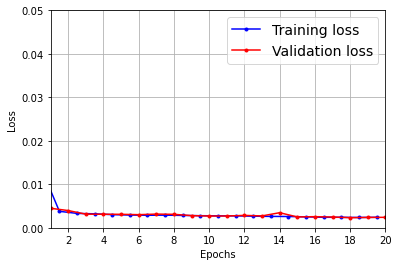

In [6]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

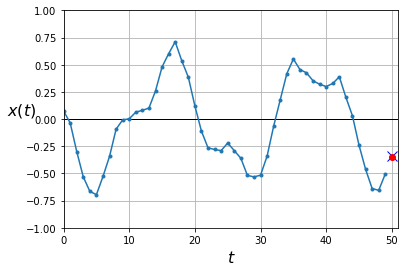

In [7]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()